In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

This notebook contains experiments with two learning schedulers.

1. Step Decay
2. Exponential Decay

The experiment is observe how these learning schedules impact learning loss and out of set performance.

It has been found by learning rate finder starting learning rate from 1e-2 to 0.075e-4

In [2]:
import os
import math
import shutil
import random
import time
import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models,utils,optimizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,LearningRateScheduler

from util.custom_callbacks import SkipLoggerCallback,LearningRateHistoryCallback
from util.custom_callbacks import StepDecayHistoryCallback, step_decay, exp_decay, ExpDecayHistoryCallback

import matplotlib.pyplot as plt

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [4]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(25):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

In [5]:
def define_model_architecture_64_32_16(sgd_optimizer = 'sgd'):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def get_generators_for_batch_size(batch_size_p = 32):
    test_img_generator = ImageDataGenerator( rescale = 1./255)
    train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                     horizontal_flip=True, fill_mode='nearest')

    train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                      class_mode = 'categorical', batch_size=batch_size_p, subset='training')

    validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                      class_mode = 'categorical', batch_size=batch_size_p, subset='validation')

    test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                      class_mode = 'categorical',batch_size=batch_size_p, shuffle=False)
    
    return train_batches,validation_batches,test_batches

### Step Decay

In [7]:
BATCH_SIZES = [32,64]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 600

In [1]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay)
lr_history_callback = StepDecayHistoryCallback()

sgd =  optimizers.SGD(lr=0.0)

NameError: name 'SkipLoggerCallback' is not defined

In [9]:
for batch_size in BATCH_SIZES:
    print('working with batch size : %f' % batch_size)
    print('')
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    callback_list = [lrate_callback, tb_callback, skipLogger_callback, lr_history_callback]
    
    train_batches,validation_batches,test_batches = get_generators_for_batch_size(batch_size)
    
    model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/batch_size, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/batch_size, 
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    
    training_time_dict[str(batch_size)] = time.time() - start
    learning_history_dict[str(batch_size)] = history
    out_of_set_test_dict[str(batch_size)] = get_oos_test_accuracy(model)
    lr_dict[str(batch_size)] = lr_history_callback.lr
    
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))
    
    print('-'*120)

working with batch size : 32.000000

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


W0901 19:05:58.859561 139663430158144 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.684634    accuracy = 0.57    val_loss = 0.702574    val_accuracy = 0.62
epoch =   25    loss = 0.557059    accuracy = 0.71    val_loss = 0.602544    val_accuracy = 0.70
epoch =   50    loss = 0.513588    accuracy = 0.76    val_loss = 0.545482    val_accuracy = 0.77
epoch =   75    loss = 0.480966    accuracy = 0.78    val_loss = 0.524430    val_accuracy = 0.78
epoch =  100    loss = 0.465184    accuracy = 0.79    val_loss = 0.473632    val_accuracy = 0.80
epoch =  125    loss = 0.459667    accuracy = 0.79    val_loss = 0.485751    val_accuracy = 0.79
epoch =  150    loss = 0.426685    accuracy = 0.81    val_loss = 0.479662    val_accuracy = 0.80
epoch =  175    loss = 0.429560    accuracy = 0.81    val_loss = 0.442850    val_accuracy = 0.82
epoch =  200    loss = 0.407193    accuracy = 0.82    val_loss = 0.456229    val_accuracy = 0.82
epoch =  225    loss = 0.386262    accuracy = 0.85    val_loss = 0.469755    val_accuracy = 0.82
epoch =  250    loss = 0.39294

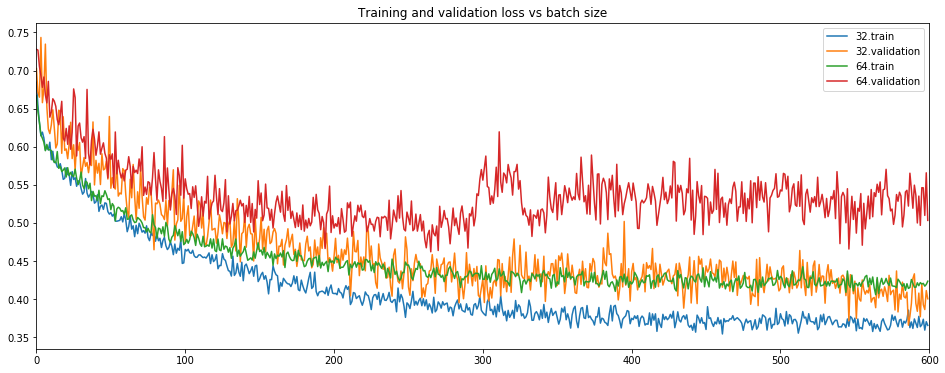

In [10]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= lr +'.train')
    plt.plot(training_history.history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

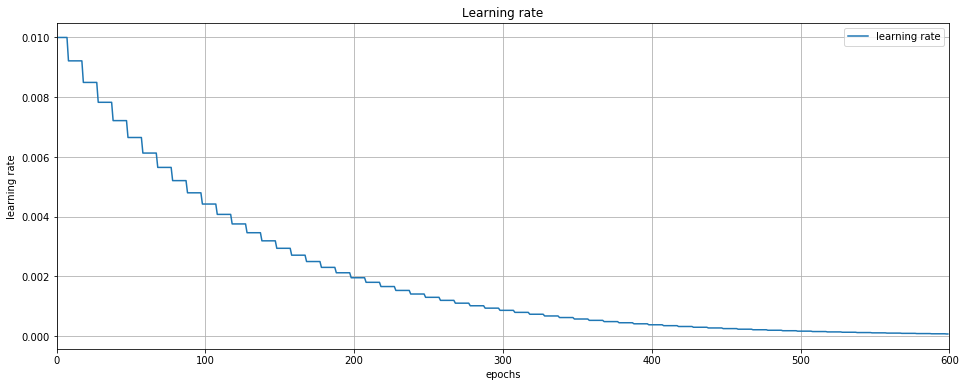

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(lr_dict['32'], label='learning rate')
plt.xlabel("epochs")
plt.xlim(0, EPOCHS)
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

In [12]:
training_time_dict

{'32': 3399.59752368927, '64': 3364.5722110271454}

In [13]:
out_of_set_test_dict

{'32': (0.8529143, 0.047327776), '64': (0.82289726, 0.06901465)}

### Exponential Decay

In [16]:
BATCH_SIZES = [32,64]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 600

In [17]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(exp_decay)
lr_history_callback = ExpDecayHistoryCallback()

sgd =  optimizers.SGD(lr=0.0)

In [18]:
for batch_size in BATCH_SIZES:
    print('working with batch size : %f' % batch_size)
    print('')
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    callback_list = [lrate_callback, tb_callback, skipLogger_callback, lr_history_callback]
    
    train_batches,validation_batches,test_batches = get_generators_for_batch_size(batch_size)
    
    model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/batch_size, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/batch_size, 
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    
    training_time_dict[str(batch_size)] = time.time() - start
    learning_history_dict[str(batch_size)] = history
    out_of_set_test_dict[str(batch_size)] = get_oos_test_accuracy(model)
    lr_dict[str(batch_size)] = lr_history_callback.lr
    
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))
    
    print('-'*120)

working with batch size : 32.000000

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.
epoch =    0    loss = 0.663448    accuracy = 0.59    val_loss = 0.650811    val_accuracy = 0.68
epoch =   25    loss = 0.539715    accuracy = 0.73    val_loss = 0.557321    val_accuracy = 0.72
epoch =   50    loss = 0.502060    accuracy = 0.76    val_loss = 0.531312    val_accuracy = 0.74
epoch =   75    loss = 0.467847    accuracy = 0.79    val_loss = 0.522102    val_accuracy = 0.77
epoch =  100    loss = 0.436289    accuracy = 0.81    val_loss = 0.461247    val_accuracy = 0.80
epoch =  125    loss = 0.428946    accuracy = 0.81    val_loss = 0.472964    val_accuracy = 0.77
epoch =  150    loss = 0.427991    accuracy = 0.81    val_loss = 0.466640    val_accuracy = 0.77
epoch =  175    loss = 0.416799    accuracy = 0.82    val_loss = 0.451184    val_accuracy = 0.81
epoch =  200    loss = 0.417523    accuracy = 0.82    val_loss 

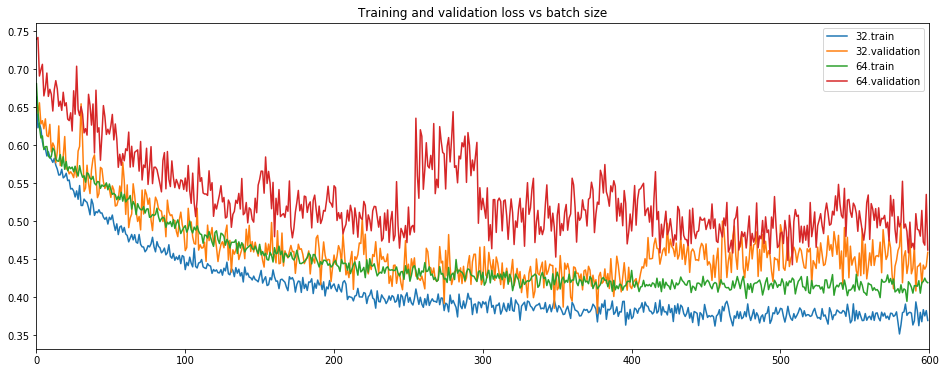

In [19]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= lr +'.train')
    plt.plot(training_history.history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

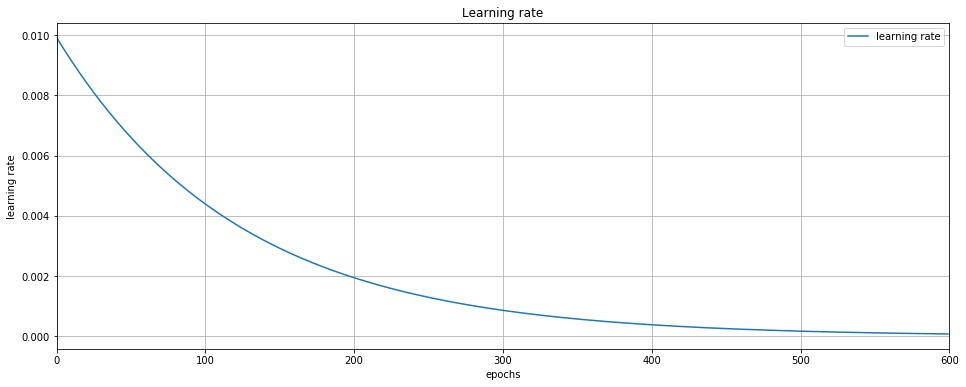

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(lr_dict['32'], label='learning rate')
plt.xlabel("epochs")
plt.xlim(0, EPOCHS)
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

In [21]:
training_time_dict

{'32': 3395.0635187625885, '64': 3306.4403989315033}

In [22]:
out_of_set_test_dict

{'32': (0.8229313, 0.06292755), '64': (0.8319203, 0.05075939)}